# Model description

This is a model of the interplay of three factors:
- The QUD
- (Unknown) The position of EXH operator
- (Unknown) The speaker's belief state

The listener computes a joint distribution over QUD-relevant belief states $b$ and possible parses $p$ given the phonological form $\phi$. A (partial) answer to the QUD can in principle be inferred from the parse. The possible parses here are the possible ways of inserting a single EXH in the phonological form. We assume a silent EXH operator that does not show in $\phi$ but might be part of $p$. Call $\forall_{EXH}(\phi)$ the set of all parses compatible with $\phi$.

\begin{align}
P_{L1}(b \mid \phi)
&= \sum_{p \in PARSES(\phi)} P_{L1}(b, p \mid \phi) & \text{Equation (19) in Franke and Bergen (2020)} \\
&= \sum_{p \in PARSES(\phi)} P_{L1}(p \mid \phi)P_{L1}(b \mid p, \phi) \\
&= \frac{1}{|\forall_{EXH}(\phi)|} \sum_{p \in \forall_{EXH}(\phi)} P_{L1}(b \mid p, \phi) & \text{Possible parses of utterance are equally probable}
\end{align}


At this point we need a way of computing $P_{L1}(b \mid p, \phi)$: how probable for the listener is a speaker's belief given a parse $p$? There are many solutions, but here are two:
1. Assume an $S_0$ that samples a parse uniformly from parses compatible with the meaning.
2. Assume an $S_1$ that tends to produce a parse that is more relevant to answering the QUD:

$$
P_{L1}(b \mid p, \phi) \propto P_{S1}( [\![ p ]\!] \mid b, \phi) P_{L1}(b) 
$$

Some points:
- Sample $b$ w/ LOTlib, check with z3 that $b$ entails $s$ (else return -inf), and if so calculate the actual quantities.
- This assumes DAG $o \rightarrow u \rightarrow \phi$, but in future the communicative intention $i$ could be added ($o \rightarrow i \rightarrow u \rightarrow \phi$), which can depend on the speaker's goals independently of the QUD.

At this point we have three components to unpack:
- $\forall_{EXH}(\phi)$
  - The set of utterances compatible with the given phonological form.
- $P_{S1}([\![ p ]\!] \mid b) \propto \texttt{softmax}_\lambda -\text{KL}\left( P_{S1}( A \mid b) ||  P_{L0}( A \mid p) \right)$
    - The (normalized) probability that the speaker will choose an utterance given an observation.
    - The speaker's goal is to answer the QUD as well as possible, and this is of course a function of the meaning of the utterance.
    - $A$ is the random variable "Answer to the QUD"
    - Calculating $P_{S1}( A \mid b)$:
        - This is brutally simplified: $P_{S1}( A \mid b) \propto (A \land b) \nvDash \bot$.
        - Basically, all answers incompatible with the belief get prob 0, and the remaining answers are equiprobable. 
        - Alternative strategy (but more complicated to implement): The probability of each answer is proportional to the number of models compatible with $o$ that belong to that answer.
    - Calculating $P_{L0}( A | p ))$:
        - Again, brutally simplified in a similar way: $P_{L0}( A | p )) \propto (A \land [\![ p ]\!]) \nvDash \bot$
        - Alternative (old - not really sure what I meant here):
            - First, we approximate for each answer $a \in A$ how many models are compatible with $a$. For every answer $a$ sample observations that the meaning is compatible with, up to a MAX, e.g., 10. Call this number $\#_a$. This defines a distribution over answers to the QUD given $b$. Since the QUD partitions the possibilities, a singleton $b$ must provide a single answer, but a $b$ with multiple possible worlds (representing uncertainty) could be compatible with multiple answers.
                - If the QUD is yes/no, we recover a discrete approximation of usual RSA $L0$.
                - This means that the speaker only keeps track of a few observations for each answers to the QUD.
            - Compute a discrete approximation to KL divergence.
            - NOTE: Not adding a cost for conceptual complexity yet, but it would relate to the discussion of conceptual complexity by Buccola.
            - The consequence of this term is that listeners will tend to guess an observations fits closely to the meaning. So for instance meaning "a" (compatible with $b$ and $\neg b$)
- $P_{L1}(b) = P_{S1}(b) * \mathbb{C}(b)$
    - The total probability of the speaker having that belief.
    - $P^{QUD}_{S1}(b)$ is the  QUD-dependent probability that the speaker has a certain belief. E.g., the listener might expect the speaker to be well-informed, i.e., might expect $b$ to resolve many of the partitions of the QUD.
    - $\mathbb{C}(b)$ is the prior as induced by the pLoT - dealt with by LOTlib3. It makes complex beliefs less probable.
 
Various to note:
- I assume there's an underlying QUD. The agents have some prior distribution over the answers to the QUD, which depends on their world model.
    - The QUD is modelled as a list of z3 objects, one for each *answer* to the QUD.
    - For instance the QUD "Who is P?" is represented as: `[ And([P(a),P(b)]), And([Not(P(a)),P(b)]), And([P(a),Not(P(b))]), And([Not(P(a)),Not(P(b))]) ]`
    - This is one way to model a partition of the possible worlds.

Examples to explain:
- "p" -> "p and not q" w/ QUD="What is true?" w/ the speaker probably knowing whether p and q
- "Not _p_" -> "not p or q" w/ QUD="what is true?" 
- "John talked to Mary or Sue" -> not both (Fox and Spector 2019)
- "Some boys came" -> not all (Fox and Spector 2019)
- "John didn't do the reading OR the homework, he did both" -> not a contradiction! (Fox and Spector 2019)
- "John talked to Mary, or to both Mary and Sue" -> not equivalent to just "Mary" (Trinh 2019)
- Contextual scales:
    - a. A: Do you speak Portuguese? B: My husband's brother does. implicature: B/her husband does not speak Portuguese.
    - (https://www.tandfonline.com/doi/full/10.1080/0163853X.2017.1316038)
- Different focuses:
    - a. A: How many children does Nigel have? B: Nigel has fourteen$_F$ children.
    - b. A: Who has fourteen children? B: Nigel$_F$ has fourteen children.
    - (https://www.tandfonline.com/doi/full/10.1080/0163853X.2017.1316038)

# Model illustration

In [3]:
import z3
import numpy as np
from functools import cache
from pprint import pprint
%load_ext line_profiler

from importlib import reload
import matplotlib.pyplot as plt

In [2]:
import itertools
import networkx as nx
from tqdm import tqdm
from io import BytesIO
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import html

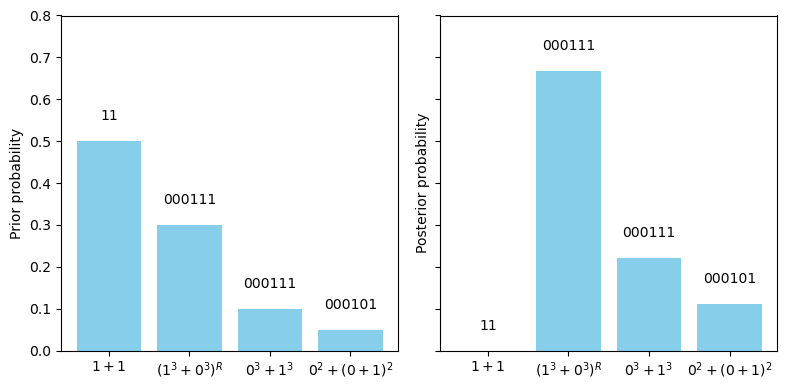

In [16]:
# Define candidate expressions and their assumed prior probabilities.
expressions = [r"$1+1$", r"$(1^3+0^3)^R$", r"$0^3+1^3$", r"$0^2+(0+1)^2$"]
# Here, we assume that simpler (shorter) expressions get higher prior.
priors = [0.5, 0.3, 0.1, 0.05]
generated_strings = ["11", "000111", "000111", "000101"]
posteriors = np.array([0]+priors[1:])/sum(priors[1:])

# Create a figure with two subplots: one for the prior and one for the posterior.
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

axs[0].bar(expressions, priors, color="skyblue")
axs[0].set_ylabel("Prior probability")

# Annotate each bar with the binary string produced by the expression.
for i, (expr, gen_str) in enumerate(zip(expressions, generated_strings)):
    axs[0].text(i, priors[i] + 0.05, f"{gen_str}", ha="center", fontsize=10)

axs[1].bar(expressions, posteriors, color="skyblue")
axs[1].set_ylabel("Posterior probability")
axs[1].set_ylim(0, 0.8)

# Annotate each bar with the binary string produced by the expression.
for i, (expr, gen_str) in enumerate(zip(expressions, generated_strings)):
    axs[1].text(i, posteriors[i] + 0.05, f"{gen_str}", ha="center", fontsize=10)

plt.tight_layout()
fig.savefig('figures/pLoTexample.png', dpi=300)


/tmp/ipykernel_4168/3616872003.py:86: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G, prog='twopi', root=0)


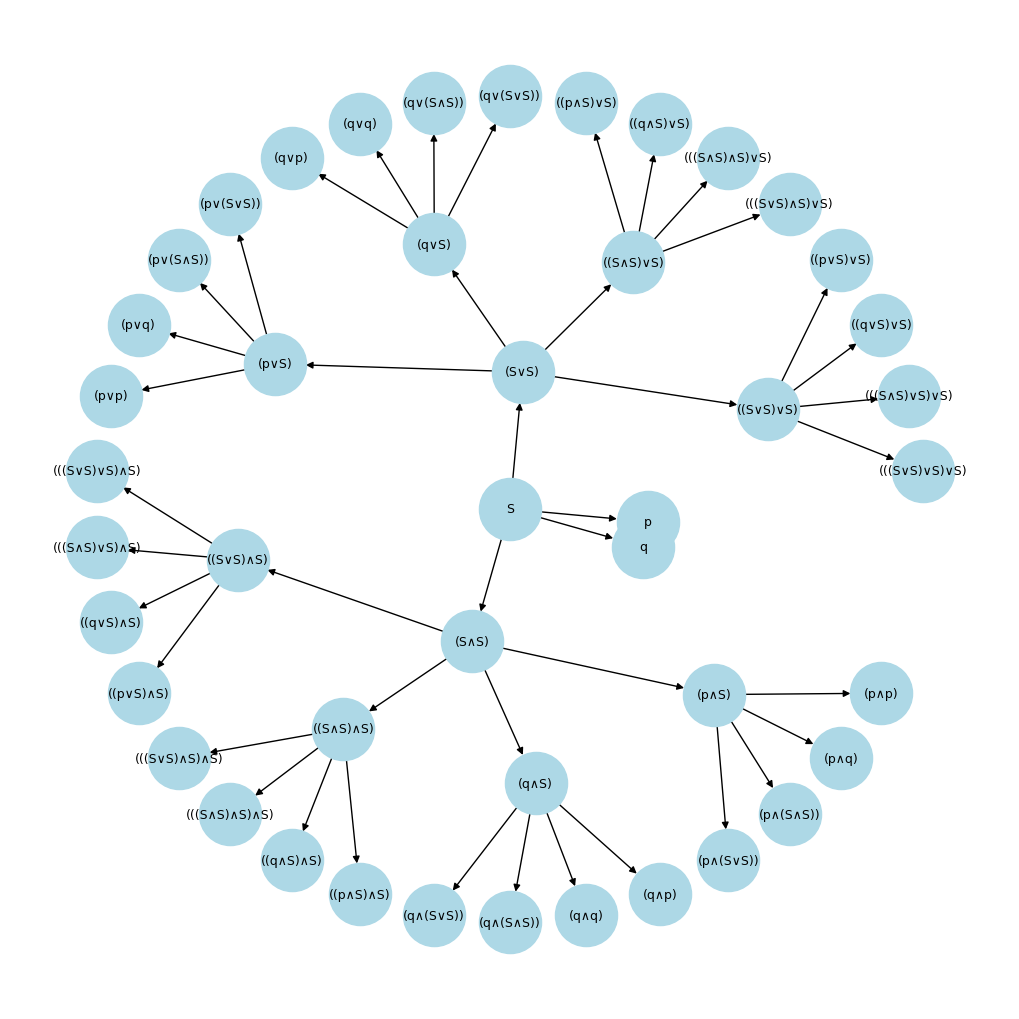

In [31]:
import matplotlib.pyplot as plt
import networkx as nx

# # Define the grammar.
# # Nonterminals are "S" and "I"; all other symbols are terminals.
# grammar = {
#     "S": [
#         ("(", "S", "+", "S", ")"),
#         ("S", "^", "R"),
#         ("S", "^", "I"),
#         ("0",),
#         ("1",)
#     ],
#     "I": [
#         ("1",),
#         ("2",),
#         ("3",)
#     ]
# }

grammar = {
    "S": [
        ("(", "S", "∨", "S", ")"),
        ("(", "S", "∧", "S", ")"),
        ("q",),
        ("p",)
    ]
}

def expand_sentence(tokens, max_depth):
    """
    Recursively expands the leftmost nonterminal in the sentence (represented as a list of tokens).
    Each node corresponds to a sentence generated so far.
    If no nonterminal remains or max_depth is reached, returns a leaf node.
    """
    sentence = "".join(tokens)  # Create a string representation.
    # If we've reached max_depth or no token is a nonterminal, return the sentence as a leaf.
    if max_depth == 0 or not any(tok in grammar for tok in tokens):
        return {"label": sentence, "children": []}
    
    # Find the leftmost nonterminal.
    for i, tok in enumerate(tokens):
        if tok in grammar:
            nonterminal = tok
            index = i
            break

    children = []
    # For each production alternative for this nonterminal,
    # substitute the production into the current token list.
    for production in grammar[nonterminal]:
        new_tokens = tokens[:index] + list(production) + tokens[index+1:]
        child_node = expand_sentence(new_tokens, max_depth - 1)
        children.append(child_node)
    
    return {"label": sentence, "children": children}

# Build the derivation tree starting from the initial sentence ["S"].
# Adjust the depth as desired; higher depth gives more complete formulas.
tree = expand_sentence(["S"], max_depth=3)

# Build a NetworkX DiGraph from the tree.
G = nx.DiGraph()

def add_nodes_edges(tree, graph, parent=None, counter=[0]):
    """
    Recursively adds nodes and edges from the nested tree dictionary into the graph.
    A mutable counter assigns a unique ID to each node.
    """
    current_id = counter[0]
    graph.add_node(current_id, label=tree["label"])
    if parent is not None:
        graph.add_edge(parent, current_id)
    counter[0] += 1
    for child in tree["children"]:
        add_nodes_edges(child, graph, parent=current_id, counter=counter)

add_nodes_edges(tree, G)

# Compute a layout for the tree.
# Use Graphviz's 'twopi' layout to get a radial layout.
# You need either PyGraphviz or pydot for this.
try:
    pos = nx.nx_agraph.graphviz_layout(G, prog='twopi', root=0)
except ImportError:
    pos = nx.nx_pydot.graphviz_layout(G, prog='twopi', root=0)

# Extract labels for drawing.
labels = nx.get_node_attributes(G, 'label')

plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, labels=labels, node_size=2000, node_color="lightblue", font_size=9)
plt.savefig('figures/booltree.png', dpi=300)
